In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import holidays
import numpy as np
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.model_selection import ParameterGrid

# load the aggregated flight data
data = pd.read_csv("../data/aggregated_flight_data.csv")
data.head()


,Carrier Reported Date of Data: Year,Carrier Reported Date of Data: Month,Carrier Reported Origin Airport: Alpha Code,Origin Airport: Unique Numeric Code,Origin Airport: World Area Code,Origin Airport: City Name,Carrier Reported Destination Airport: Alpha Code,Destination Airport: Numeric Code,Destination Airport: World Area Code,Destination Airport: City Name,...,Available Capacity: Payload Pounds,Available Seats,Passengers Transported,Freight Transported,Mail Transported,Ramp – Ramp in minutes,Airborne – in minutes,Carrier’s World Area Code,Carrier’s World Area Code (Duplicate),Load_Factor_Calculated
0,2021,7,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",EWR,31703,21,"Newark, NJ",...,40100,172,9,1,1185,46,22,10.0,NaN,0.052326
1,2021,7,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",JFK,31703,22,"New York, NY",...,48400,102,16,0,0,50,31,10.0,NaN,0.156863
2,2020,11,ABE,30135,23,"Allentown/Bethlehem/Easton, PA",PHL,34100,23,"Philadelphia, PA",...,40100,172,39,119,0,33,21,10.0,NaN,0.226744
3,2021,5,ABI,30136,74,"Abilene, TX",DFW,30194,74,"Dallas/Fort Worth, TX",...,38400,150,148,0,215,54,40,10.0,NaN,0.986667
4,2021,4,ABI,30136,74,"Abilene, TX",DFW,30194,74,"Dallas/Fort Worth, TX",...,35600,128,88,0,0,74,37,10.0,NaN,0.687500


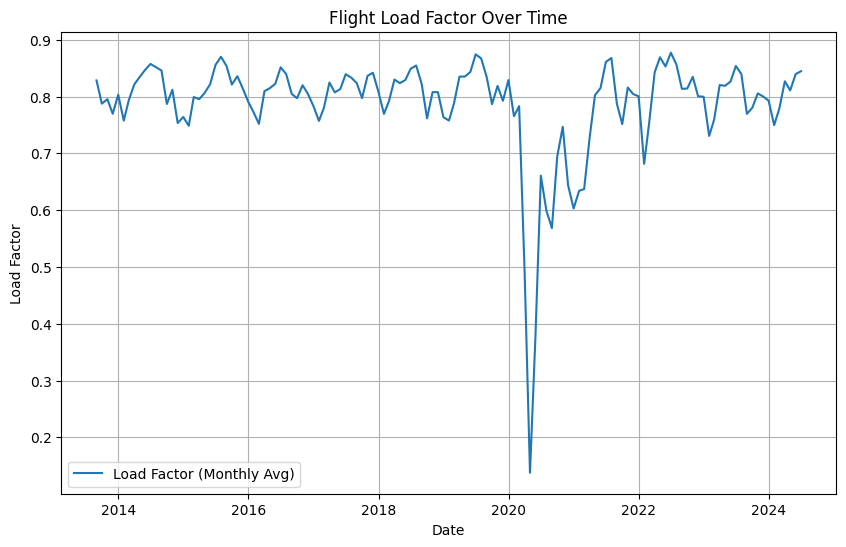

In [2]:
data['Date'] = pd.to_datetime(data['Carrier Reported Date of Data: Year'].astype(str) + '-' + 
                              data['Carrier Reported Date of Data: Month'].astype(str), format='%Y-%m')
data.set_index('Date', inplace=True)

# resample data to monthly averages (or another appropriate frequency)
data_resampled = data['Load_Factor_Calculated'].resample('ME').mean()

# plot the resampled data
plt.figure(figsize=(10, 6))
plt.plot(data_resampled.index, data_resampled, label='Load Factor (Monthly Avg)')
plt.title('Flight Load Factor Over Time')
plt.xlabel('Date')
plt.ylabel('Load Factor')
plt.grid(True)
plt.legend()
plt.show()


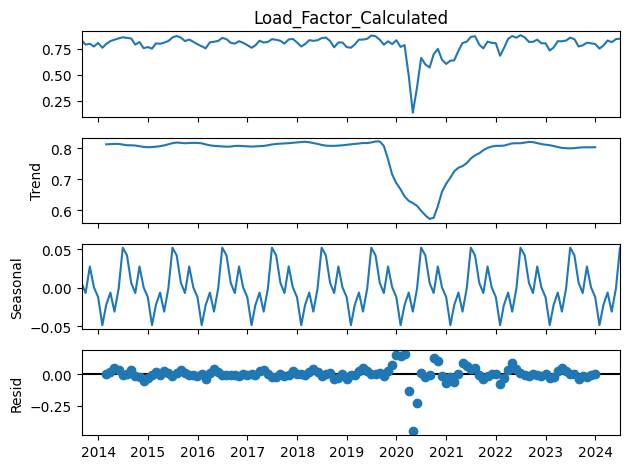

In [3]:
# perform seasonal decomposition (assuming monthly data, hence period=12)
decomposition = seasonal_decompose(data_resampled, model='additive', period=12)

# plot the decomposition
decomposition.plot()
plt.show()

In [4]:
# resample the data to monthly frequency, taking the mean of 'Load_Factor_Calculated'
monthly_data = data['Load_Factor_Calculated'].resample('ME').mean()
monthly_data = monthly_data.dropna()

# reset the index to have 'Date' as a column again
monthly_data = monthly_data.reset_index()

# rename the columns to 'ds' and 'y' as required by Prophet
monthly_data.columns = ['ds', 'y']
print(monthly_data.head())

          ds         y
0 2013-08-31  0.828379
1 2013-09-30  0.787506
2 2013-10-31  0.795360
3 2013-11-30  0.769716
4 2013-12-31  0.803287


In [5]:
covid_disruption = pd.DataFrame({
    'holiday': 'covid_disruption',
    'ds': pd.to_datetime(['2020-03-01', '2023-04-30']),
    'lower_window': 0,
    'upper_window': 0,
})
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.2],
    'seasonality_prior_scale': [5.0, 10.0, 20.0]
}

# create combinations of all parameters
grid = ParameterGrid(param_grid)

# track best MAE
best_params = None
best_mae = float('inf')

for params in grid:
    # initialize Prophet model with parameters from the grid
    model = Prophet(changepoint_prior_scale=params['changepoint_prior_scale'],
                    seasonality_prior_scale=params['seasonality_prior_scale'],
                    holidays=covid_disruption)
    
    # add yearly and quarterly seasonality
    model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
    
    # add country holidays (US)
    model.add_country_holidays(country_name='US')
    
    # specify changepoints manually for known disruptions like COVID-19
    changepoints = ['2020-03-01']  # Adjust this if you have other known points
    model.changepoints = pd.to_datetime(changepoints)
    
    # fit the model
    model.fit(monthly_data)
    
    # perform cross-validation with specified initial period, horizon, and period
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    
    # calculate performance metrics
    df_p = performance_metrics(df_cv)
    
    # check if the current model is better
    current_mae = df_p['mae'].mean()
    if current_mae < best_mae:
        best_mae = current_mae
        best_params = params

# print the best parameters and MAE
print(f"Best Parameters: {best_params}, Best MAE: {best_mae}")


14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
14:22:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/16 [00:00<?, ?it/s]14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:00<00:02,  5.43it/s]14:22:50 - cmdstanpy - INFO - Chain [1] start processing
14:22:50 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:00<00:02,  4.74it/s]14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:00<00:02,  4.95it/s]14:22:51 - cmdstanpy - INFO - Chain [1] start processing
14:22:51 - cmdstanpy - INFO - Chain [1] done p

Best Parameters: {'changepoint_prior_scale': 0.2, 'seasonality_prior_scale': 5.0}, Best MAE: 0.24884056402340046


14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


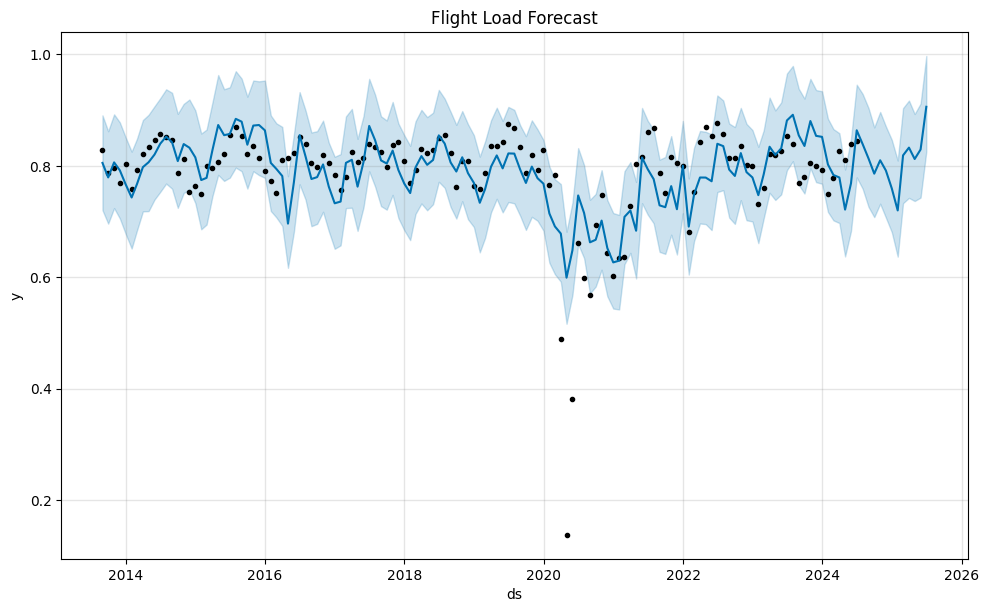

In [6]:
# refit the Prophet model with best parameters
best_model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=5.0, holidays=covid_disruption)
best_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
best_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
best_model.add_country_holidays(country_name='US')

# fit the model to the data
best_model.fit(monthly_data)

# create a future dataframe (e.g., for the next 12 months)
future = best_model.make_future_dataframe(periods=12, freq='ME')

# predict future flight loads
forecast = best_model.predict(future)

# plot forecast
best_model.plot(forecast)
plt.title('Flight Load Forecast')
plt.show()

In [7]:
# refit the Prophet model with best parameters
best_model = Prophet(changepoint_prior_scale=0.2, seasonality_prior_scale=5.0, holidays=covid_disruption, interval_width=0.95)
best_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
best_model.add_seasonality(name='quarterly', period=91.25, fourier_order=8)
best_model.add_country_holidays(country_name='US')

# fit the model on the full dataset
best_model.fit(monthly_data)

# perform cross-validation
# Initial period: 730 days (2 years), Period: 180 days, Horizon: 365 days (1 year forecast)
df_cv = cross_validation(best_model, initial='730 days', period='180 days', horizon='365 days')

# compute performance metrics like MAE, RMSE, and sMAPE for each time window
df_p = performance_metrics(df_cv)

# display the performance metrics
print(df_p[['horizon', 'mae', 'rmse', 'mape', 'mdape', 'coverage']])

14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:28:43 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 0/16 [00:00<?, ?it/s]14:28:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:03 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 1/16 [00:19<04:51, 19.40s/it]14:29:03 - cmdstanpy - INFO - Chain [1] start processing
14:29:22 - cmdstanpy - INFO - Chain [1] done processing
 12%|█▎        | 2/16 [00:39<04:35, 19.65s/it]14:29:23 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
 19%|█▉        | 3/16 [00:59<04:20, 20.04s/it]14:29:43 - cmdstanpy - INFO - Chain [1] start processing
14:29:43 - cmdstanpy - INFO - Chain [1] done processing
 25%|██▌       | 4/16 [01:00<02:27, 12.31s/it]14:29:44 - cmdstanpy - INFO - Chain [1] start processing
14:29:44 - cmdstanpy - INFO - Chain [1] done processing
 31%|███▏      | 5/16 [01:00<01:28,  8.03s/it]14:29:44 - cmdstanpy - INFO - Chain [1] start processi

     horizon       mae      rmse      mape     mdape  coverage
0    36 days  0.188681  0.501523  0.251590  0.061970  0.368421
1    40 days  0.188402  0.501515  0.251172  0.061970  0.421053
2    42 days  0.189234  0.501543  0.252284  0.061970  0.368421
3    46 days  0.216396  0.516649  0.300655  0.071493  0.368421
4    47 days  0.219567  0.516848  0.305683  0.098208  0.368421
..       ...       ...       ...       ...       ...       ...
146 358 days  0.238092  0.407031  0.307290  0.168188  0.421053
147 359 days  0.215903  0.387684  0.279222  0.138430  0.447368
148 363 days  0.204308  0.371558  0.264939  0.168188  0.421053
149 364 days  0.199093  0.370300  0.258547  0.162552  0.473684
150 365 days  0.196708  0.369692  0.255372  0.162552  0.500000

[151 rows x 6 columns]


In [8]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('../data/flight_load_forecast.csv', index=False)

# check where the file was saved (if running locally)
print("Forecast saved to 'flight_load_forecast.csv'")


Forecast saved to 'flight_load_forecast.csv'


/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


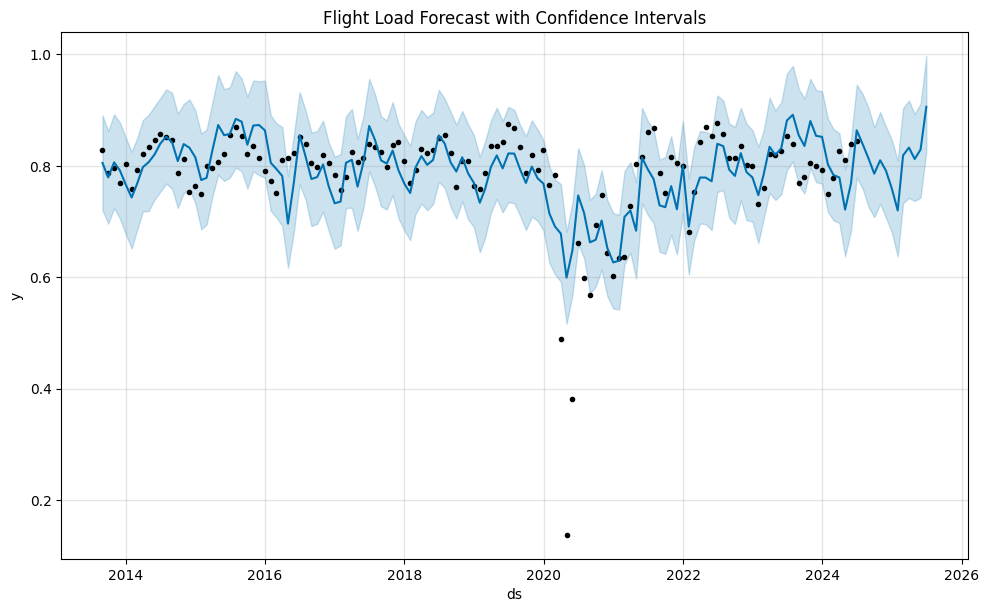

In [9]:
best_model.plot(forecast)
plt.title('Flight Load Forecast with Confidence Intervals')
plt.show()